In [1]:
import pandas as pd
import numpy as np
import datetime 
import time

import sys

import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

from pyspark.ml.recommendation import ALS
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt 

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
events=spark.read.csv('data/events.csv',  header= True, inferSchema = True)
events = events.withColumn('datetime', f.from_unixtime((events.timestamp.cast('bigint')/1000)).cast('timestamp'))
events = events.withColumn('date',f.to_date(events['datetime']))

events = events.withColumn('hour_of_day',f.hour(events['datetime']))

In [6]:
df_niview = events.where(f.col("event") =="view").groupby("visitorid",'date').\
agg(f.countDistinct("itemid"))
df_niview = df_niview.withColumn('comsum_niview', f.sum(df_niview['count(itemid)'])\
                               .over(Window.partitionBy("visitorid").orderBy('date').rowsBetween(-sys.maxsize, 0)))

df_nview = events.where(f.col("event") =="view").groupby("visitorid",'date').\
agg(f.count("event"))
df_nview = df_nview.withColumn('comsum_nview', f.sum(df_nview['count(event)'])\
                               .over(Window.partitionBy("visitorid").orderBy('date').rowsBetween(-sys.maxsize, 0)))

In [7]:
df_at = events.where(f.col("event") =="addtocart").groupby("visitorid","date").agg(f.count("event"))
df_at = df_at.toDF('visitorid','date','label')

In [15]:
df_final = df_niview.join(df_nview, on =["visitorid",'date'],how = 'inner')
df_final = df_final.withColumn('day_of_week',f.dayofweek(df_final['date']))
df_final = df_final.withColumn('day_of_month',f.dayofmonth(df_final['date']))
df_final = df_final.join(df_at,on = ["visitorid",'date'],how = 'outer')
df_final = df_final.na.fill(0)

#convert number of addtocart to labels 0, 1
def convert_event_addtocart(n_addtocart):
    if n_addtocart >=1:
        return 1
    return 0

udf_convert_addtocart = f.udf(convert_event_addtocart, IntegerType())
df_final = df_final.withColumn("label", udf_convert_addtocart(f.col("label")))

In [16]:
df_final.count()

1648746

In [17]:
df_final.where(f.col('label')==1).count()

41469

In [18]:
df_final.where(f.col('label')==0).count()

1607277

In [19]:
#convert data to format of pyspark ml
cols = df_final.columns
cols.remove('visitorid')
cols.remove('label')
cols.remove('date')

assembler = VectorAssembler(inputCols=cols,outputCol="features")
data=assembler.transform(df_final)

#normalize data
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
data=standardscaler.fit(data).transform(data)

# split data to training set and testing set
train,test = data.randomSplit([0.8, 0.2], seed = 42)

#imbalancing handling: most samples have labels zeros

dataset_size=float(train.select("label").count())
numPositives=train.select("label").where('label == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

train=train.withColumn("classWeights", f.when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))


The number of ones are 33177
Percentage of ones are 2.514843694925969
BalancingRatio = 0.9748515630507403


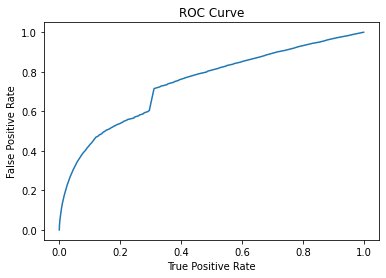

Training set areaUnderROC: 0.7425383252333426
Test Area Under ROC 0.7390727822926089
Accuracy on testing set = 0.851089
Accuracy on testing set for labels 0 = 0.860498
Accuracy on testing set for labels 1 = 0.486614


In [20]:
lr = LogisticRegression(featuresCol = 'Scaled_features', labelCol = 'label', weightCol="classWeights", maxIter=10) 
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

lr_predictions = lrModel.transform(test)
evaluatorB = BinaryClassificationEvaluator(labelCol='label')
ROC_lr = evaluatorB.evaluate(lr_predictions)
print('Test Area Under ROC', ROC_lr)

evaluatorM = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluatorM.evaluate(lr_predictions)
accuracy0_lr = evaluatorM.evaluate(lr_predictions.where(f.col('label')==0))
accuracy1_lr = evaluatorM.evaluate(lr_predictions.where(f.col('label')==1))
print("Accuracy on testing set = %g" % accuracy_lr)
print("Accuracy on testing set for labels 0 = %g" % accuracy0_lr)
print("Accuracy on testing set for labels 1 = %g" % accuracy1_lr)


In [21]:
dt = DecisionTreeClassifier(featuresCol = 'Scaled_features', labelCol = 'label', weightCol="classWeights",maxDepth = 3)
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

ROC_dt = evaluatorB.evaluate(dt_predictions)
print('Test Area Under ROC', ROC_dt)

accuracy_dt = evaluatorM.evaluate(dt_predictions)
accuracy0_dt = evaluatorM.evaluate(dt_predictions.where(f.col('label')==0))
accuracy1_dt = evaluatorM.evaluate(dt_predictions.where(f.col('label')==1))
print("Accuracy on testing set = %g" % accuracy_dt)
print("Accuracy on testing set for labels 0 = %g" % accuracy0_dt)
print("Accuracy on testing set for labels 1 = %g" % accuracy1_dt)

Test Area Under ROC 0.65874697986082
Accuracy on testing set = 0.775092
Accuracy on testing set for labels 0 = 0.776325
Accuracy on testing set for labels 1 = 0.727328


In [22]:
rf = RandomForestClassifier(featuresCol = 'Scaled_features', labelCol = 'label',weightCol="classWeights")
rfModel = rf.fit(train)
rf_predictions = rfModel.transform(test)

ROC_rf = evaluatorB.evaluate(rf_predictions)
print('Test Area Under ROC', ROC_rf)

accuracy_rf = evaluatorM.evaluate(rf_predictions)
accuracy0_rf = evaluatorM.evaluate(rf_predictions.where(f.col('label')==0))
accuracy1_rf = evaluatorM.evaluate(rf_predictions.where(f.col('label')==1))
print("Accuracy on testing set = %g" % accuracy_rf)
print("Accuracy on testing set for labels 0 = %g" % accuracy0_rf)
print("Accuracy on testing set for labels 1 = %g" % accuracy1_rf) 


Test Area Under ROC 0.7960919897948661
Accuracy on testing set = 0.775092
Accuracy on testing set for labels 0 = 0.776325
Accuracy on testing set for labels 1 = 0.727328


In [23]:
gbt = GBTClassifier(featuresCol = 'Scaled_features', labelCol = 'label',weightCol="classWeights",maxIter=10)
gbtModel = gbt.fit(train)
gbt_predictions = gbtModel.transform(test)

ROC_gbt = evaluatorB.evaluate(gbt_predictions)
print('Test Area Under ROC', ROC_gbt)

accuracy_gbt = evaluatorM.evaluate(gbt_predictions)
accuracy0_gbt = evaluatorM.evaluate(gbt_predictions.where(f.col('label')==0))
accuracy1_gbt = evaluatorM.evaluate(gbt_predictions.where(f.col('label')==1))
print("Accuracy on testing set = %g" % accuracy_rf)
print("Accuracy on testing set for labels 0 = %g" % accuracy0_gbt)
print("Accuracy on testing set for labels 1 = %g" % accuracy1_gbt) 


Test Area Under ROC 0.7998118504222866
Accuracy on testing set = 0.775092
Accuracy on testing set for labels 0 = 0.812289
Accuracy on testing set for labels 1 = 0.696213


In [26]:
from collections import namedtuple
user_row = namedtuple('user_row', 'Method AUC ACC ACC_CLASS_0 ACC_CLASS_1'.split())
result = [
    user_row('LogisticRegression', ROC_lr, accuracy_lr,accuracy0_lr,accuracy1_lr),
    user_row('DecisionTree', ROC_dt, accuracy_dt,accuracy0_dt,accuracy1_dt),
    user_row('RandomForest', ROC_rf, accuracy_rf,accuracy0_rf,accuracy1_rf),
    user_row('GradientBoostedTree', ROC_gbt, accuracy_gbt,accuracy0_gbt,accuracy1_gbt)
]
result_df_round = spark.createDataFrame(result)
result_df_round.show()

+-------------------+------------------+------------------+------------------+------------------+
|             Method|               AUC|               ACC|       ACC_CLASS_0|       ACC_CLASS_1|
+-------------------+------------------+------------------+------------------+------------------+
| LogisticRegression|0.7390727822926089|0.8510890776603267|0.8604980588841463|0.4866136034732272|
|       DecisionTree|  0.65874697986082|0.7750918819176993|0.7763249244256819|0.7273275446213218|
|       RandomForest|0.7960919897948661|0.7750918819176993|0.7763249244256819|0.7273275446213218|
|GradientBoostedTree|0.7998118504222866|0.8093681619671076|0.8122892714044214|0.6962132175590932|
+-------------------+------------------+------------------+------------------+------------------+

